# StarCraft 2 Player Prediction (OT2B)
This notebook is destined as a product for the player prediction challenge. The challenge is to predict the player who is behind the actions given as data. Through these actions, features are to be developed to give a better descriptions and characteristics towards a certain player.

## Initialisation
All imports are specified below, this project uses the environment constrained by the Kaggle docker environment. `sklearn` is used for the machine learning models and the computation of metrics, while `pandas` is used for all data pre-processing actions.

In [1]:
import os
import re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from tqdm import tqdm

## Data Input 
The data provided gives a description of the player's actions. We shall first define functions to read the files and recover data. 2 types of data are available, one for training purposes and the other for testing, for which the results of the predictions are to be submitted. Since the input data is in the form of a ragged CSV file, we shall read the data line by line, instead of using `read_csv` for practical purposes.

In [2]:
def read_data(is_train, is_long, limit=None):
    input_dir = "./"
    data = []
    
    row = 0
    if is_train:
        file_dir = os.path.join(input_dir, "TRAIN_LONG.CSV") if is_long else os.path.join(input_dir, "TRAIN.CSV")
        with open(file_dir, 'r') as f:
            for line in f:
                if limit and row >= limit:
                    break
                line = line.replace('\n', '')
                data.append(line.split(',', 2))
                row += 1
                
        return pd.DataFrame(data, columns=["bn_url", "race", "moves"])
    else:
        file_dir = os.path.join(input_dir, "TEST_LONG.CSV") if is_long else os.path.join(input_dir, "TEST.CSV")
        with open(file_dir, 'r') as f:
            for line in f:
                if limit and row >= limit:
                    break
                line = line.replace('\n', '')
                data.append(line.split(',', 1))
                row += 1
                
        return pd.DataFrame(data, columns=["race", "moves"])
    
raw_train = read_data(True, False)
raw_train_long = read_data(True, True)

raw_test = read_data(False, False)
raw_test_long = read_data(False, True)

## Pre-processing and Data Visualization
Before providing the data for learning, it is necessary to rework the data to be able to exploit it. This includes handling noise, irrelevant data, and also creating new features. With this, there are a few raw ideas to note :

* Rows with empty moves exist in the data, which should be removed.
* The data contains moves made throughout the game, which can be unpredictable as a lot depends on the moves of the opponent as well. It is perhaps better to restrain to only the moves made before scouting the opponent, which is usually before the 2-minute mark.
* A player can be identified by their hotkey preference, which can be evaluated either by the frequence of use of each hotkey or the order in which the hotkeys are used.

We will also try to visualize the data for eventual indications. By visualizing the data, we are then able to deduce some characteristics and eventually engineer some features to interpret the data better.

#### Parsing moves
First, all the moves are parsed to ease handling of the data, as well as clean the data as the data provided presents some inconsistencies which include:

* Trailing commas,
* Commas existent in quotes during ChatEvent

In this section, we shall also discover the possible values for the concerned events.

In [3]:
def parse_long_moves(games, is_train):
    parsed_moves = []
    
    possible_values = {
        "objects": set(),
        "basic_command": set(),
        "target_point": set(),
        "target_ability": set(),
    }
    
    for index, game in tqdm(games.iterrows(), total=games.shape[0]):
        moves = [game["moves"].strip(",")]
        frame = 0
        events = []
        
        while moves:
            moves = [moves[0].lstrip(",")] # Remove extra commas
            if not moves[0]:
                break
            frame, event, *moves = moves[0].split(":", 2)
            data = None;
            if event == "SelectionEvent":
                objects, *moves = moves[0].split(",", 1)
                data = objects.split(";")
                possible_values["objects"].update(data)
            elif event == "ControlGroupEvent":
                ctrl_grp, *moves = moves[0].split(",", 1)
                data = ctrl_grp.split(":")
            elif event == "CameraEvent":
                position, *moves = moves[0].split(",", 1)
                data = position.split(":")
            elif event == "ChatEvent":
                index = moves[0].index('"', 1)
                chat = moves[0][1:index]
                moves = [moves[0][index+1:]]
                data = chat
            elif event == "BasicCommandEvent":
                ability, *moves = moves[0].split(",", 1)
                data = ability
                possible_values["basic_command"].add(data)
            elif event == "TargetPointCommandEvent":
                command, *moves = moves[0].split(",", 1)
                data = command.split(":")
                possible_values["target_point"].add(data[-1])
            elif event == "TargetUnitCommandEvent":
                command, *moves = moves[0].split(",", 1)
                data = command.split(":")
                possible_values["target_ability"].add(data[-2])
            events.append([frame, event, data])
            
        if is_train and int(frame) and events: # Remove games that end with frame 0
            parsed_moves.append([game["bn_url"], game["race"], events])
        elif not is_train:
            parsed_moves.append([game["race"], events])
                
    if is_train:
        return pd.DataFrame(parsed_moves, columns=("bn_url", "race", "actions")), possible_values
    else:
        return pd.DataFrame(parsed_moves, columns=("race", "actions")), possible_values

parsed_long_train, possible_train = parse_long_moves(raw_train_long, True)
parsed_long_test, possible_test = parse_long_moves(raw_test_long, False)

100%|██████████| 340/340 [00:31<00:00, 10.83it/s]


From this stage onwards, we will progressively rebuild the data frame that will be used to train the classifiers. Below, we will define a few variables that will be useful in our analysis throughout the notebook.

In [4]:
bn_urls = parsed_long_train["bn_url"]

bn_url_paralyze = "http://kr.battle.net/sc2/en/profile/2348639/1/ParalyzE/"
bn_url_soo = "http://kr.battle.net/sc2/en/profile/2342419/1/soO/"
bn_url_classic = "http://kr.battle.net/sc2/en/profile/2341467/1/Classic/"
bn_url_life = "http://kr.battle.net/sc2/en/profile/2344987/1/Life/"
bn_url_maru = "http://kr.battle.net/sc2/en/profile/2343012/1/Maru/"
bn_url_has = "http://us.battle.net/sc2/en/profile/5495016/1/Has/"

### Data Analysis
For the following sections, we shall differentiate 3 types of situations/contexts where we shall analyse different actions and engineer different features for. These situations/contexts are as follows :
* **General** - Some analysis will be done using a general view on the game. This includes the result of the game, the games duration, etc. These analysis are less affected by the stage of which the game is in.
* **Early Game** - The early stages of the game is where the player is the least affected by the opponent's moves. The actions executed in this stage are usually systematic since no scouting has been done and hence each player is playing his/her own game. This is also the stage where there are the least units in the map and a lot of time is spent on waiting. In the early game, there are a few elements which are vital. These elements include resource-gathering, probe training, and reducing supply blocks.
* **Mid - Late Game** - Mid to Late game tend to be macro and micro-heavy. Through these stages of the game, we can really see how the opponent is able to set a pace or keep up with the pace set by another player. The analysis done in this stage should be independant of strategy, as players tend to adapt their strategy according to their opponents build.

### General Analysis
#### Distribution of Games
Here we visualize the distribution of games by each player, we can see that it is not at all uniform, with some players having more games played than others. As the dataset is taken from competitions, we can infer that players with more games played are most likely to be the ones who advanced further in the tournament. However, we should keep into account that more games played does not directly mean that one player advanced further than the other (Bo5 games where there are at least 3 games played but close competition means more games played).

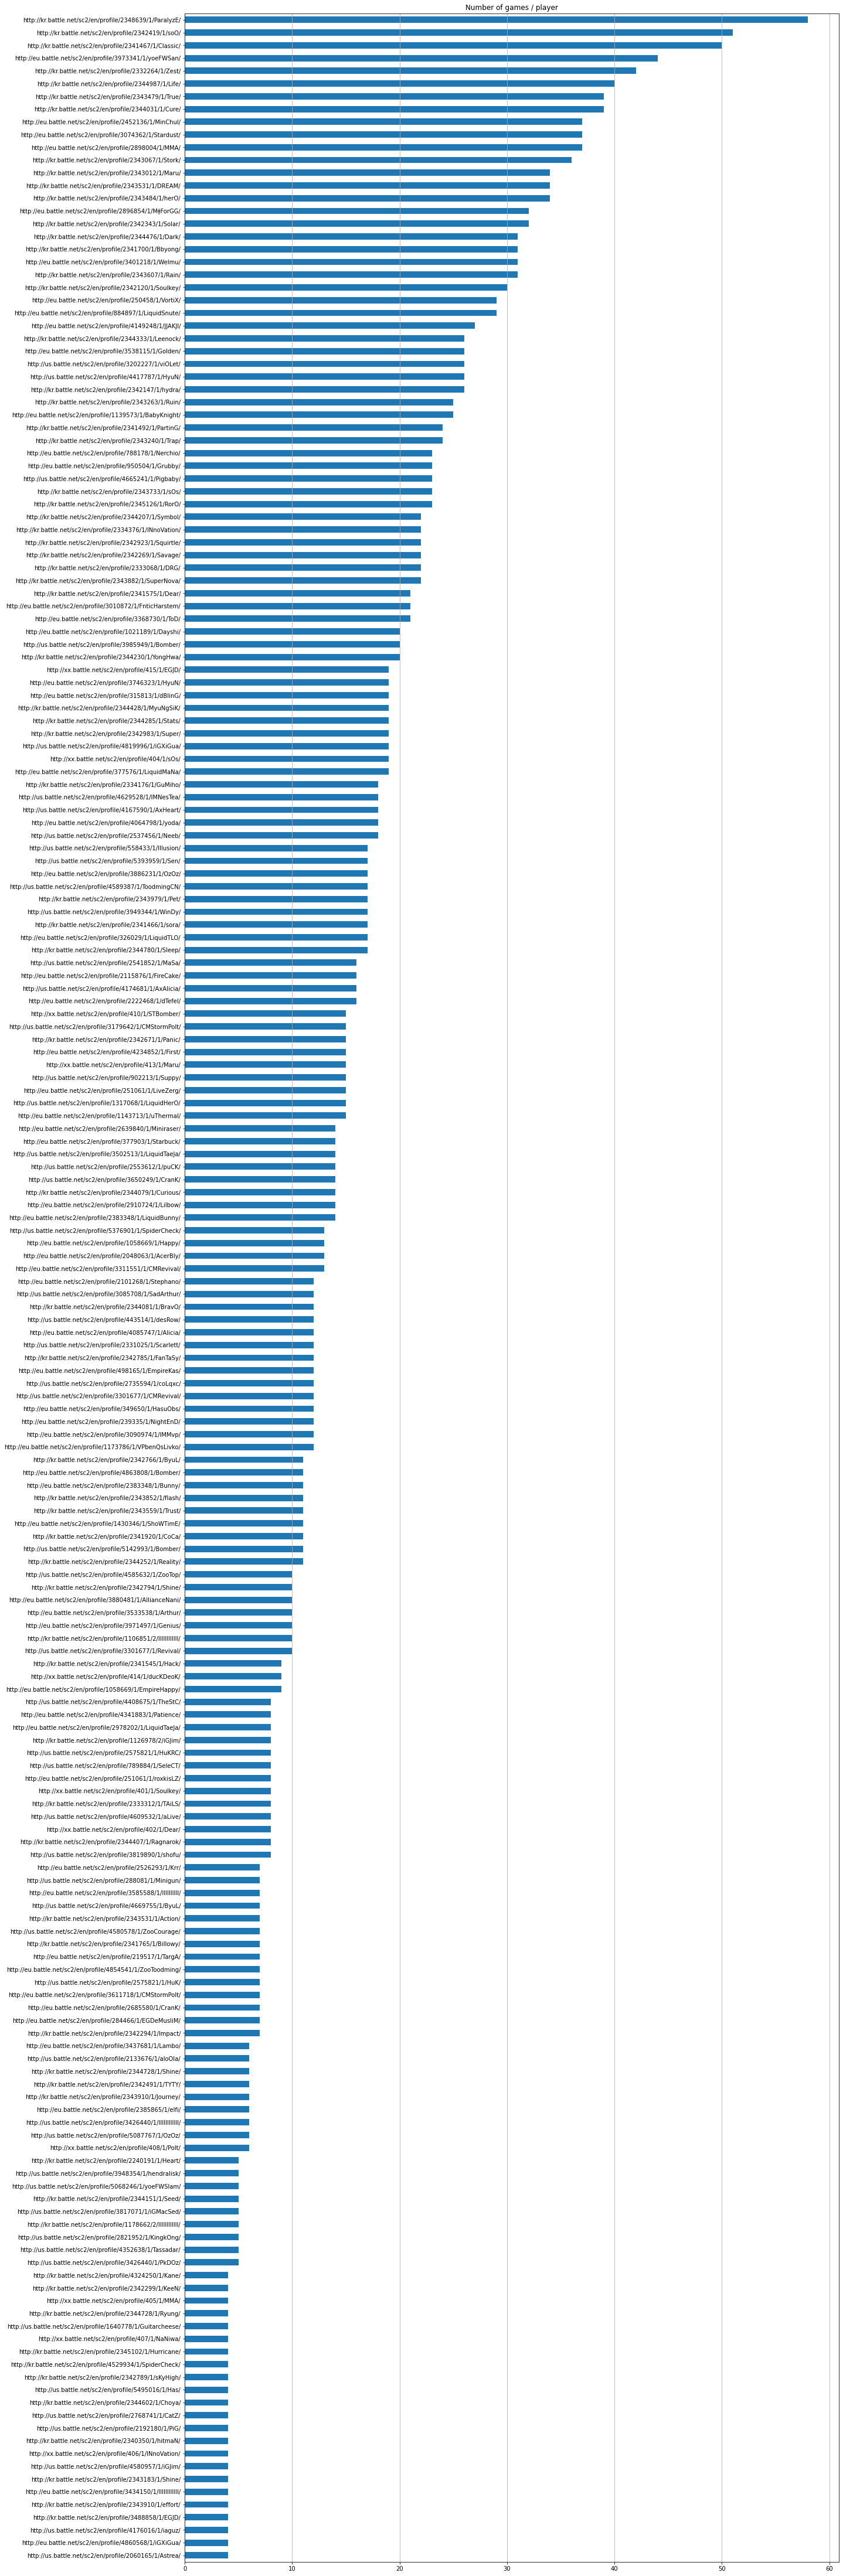

In [5]:
total_games = parsed_long_train["bn_url"].value_counts().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(20, 80))
total_games.plot.barh(ax=ax)
ax.set_title("Number of games / player")
ax.grid(True, axis="x")

#### Races played
Since the races are of type string and is a categorical data, the classifier will have a hard time interpreting the "race" field. For this, we shall use one-hot encoding to transform this categorical data into numeric data.

In [6]:
def encode_races(games):
    one_hot = pd.get_dummies(games["race"])
    return one_hot

Next, we will visualize the number of games per race from the training data set.

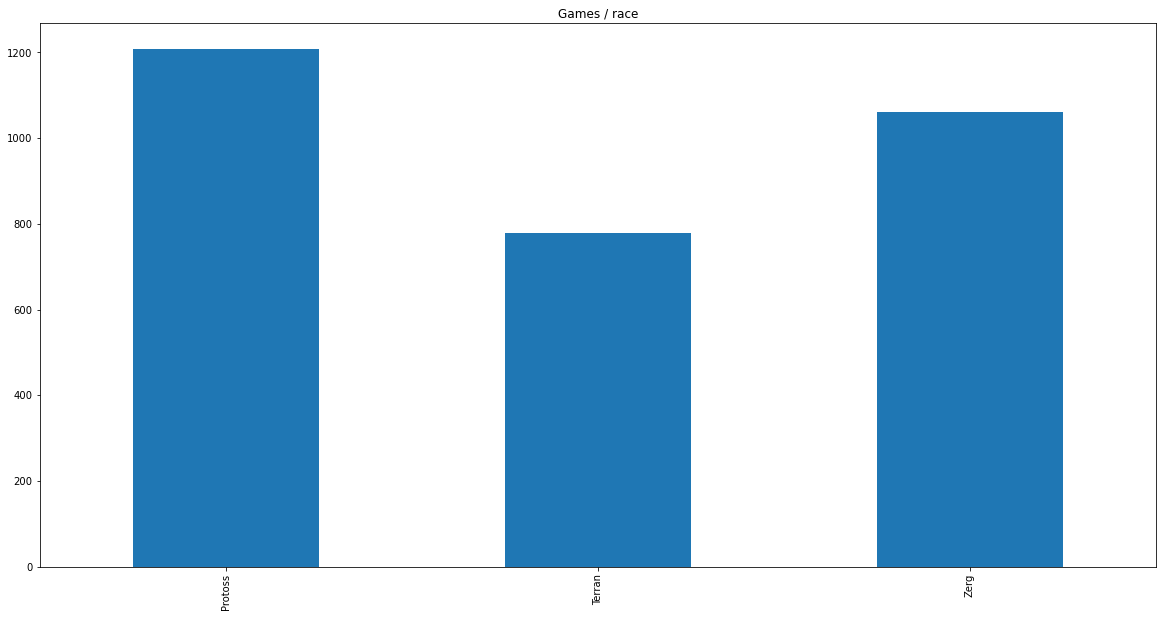

In [7]:
train_races = encode_races(parsed_long_train)
test_races = encode_races(parsed_long_test)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Games / race")
train_races.sum().plot.bar(ax=ax)

Taking a look below, we can clearly see that Protoss is the race with the most games played, followed by Zerg and then Terran. This could be due to two reasons, Protoss players advancing further in the tournament, or just more Protoss-playing participants in general. We can perhaps infer that Protoss had a favorable patch recently.

#### Game Lengths
It would also be interesting to take into account the total length of the game as a deciding factor. We can assume that longer games would correspond to macro-heavy late games while short games correspond to games with "cheese" strategy or clutch micro gameplay. Each player has their own preference and hence this is potentially capable of describing a player. We should also note that this will not be a very deciding feature as it also depends on the opponent faced.

In [8]:
def calculate_game_lengths(games):
    game_lengths = []
    for index, game in games.iterrows():
        last_frame = game["actions"][-1][0]
        game_length = int(last_frame)
        game_lengths.append(game_length)
    return pd.Series(game_lengths, name="game_length")

Here we shall try to have a look at the distribution of the game lengths.

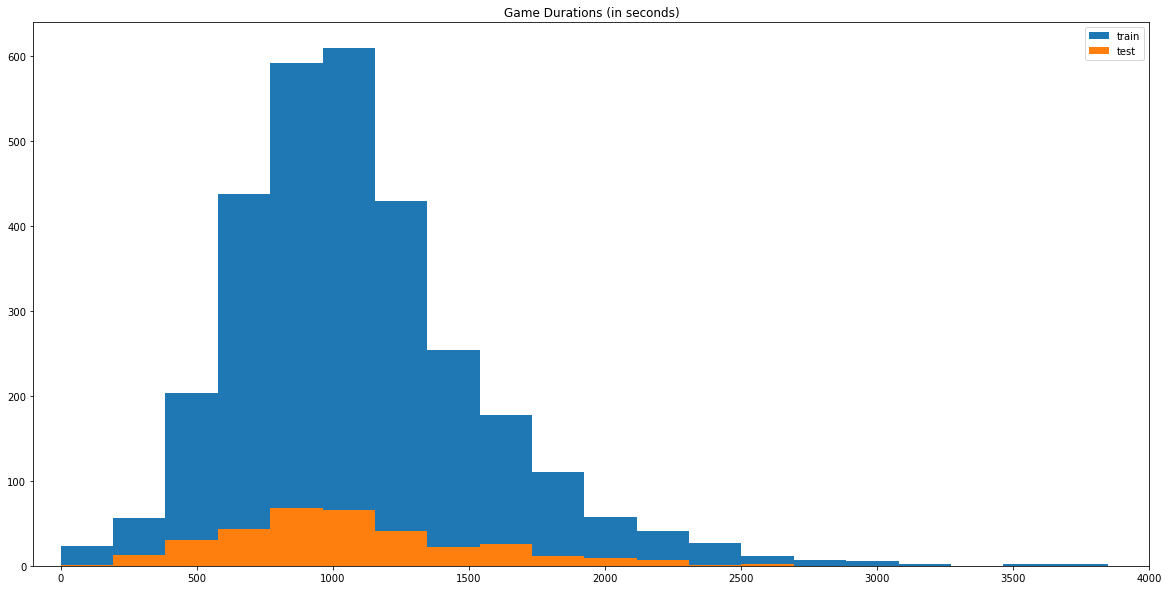

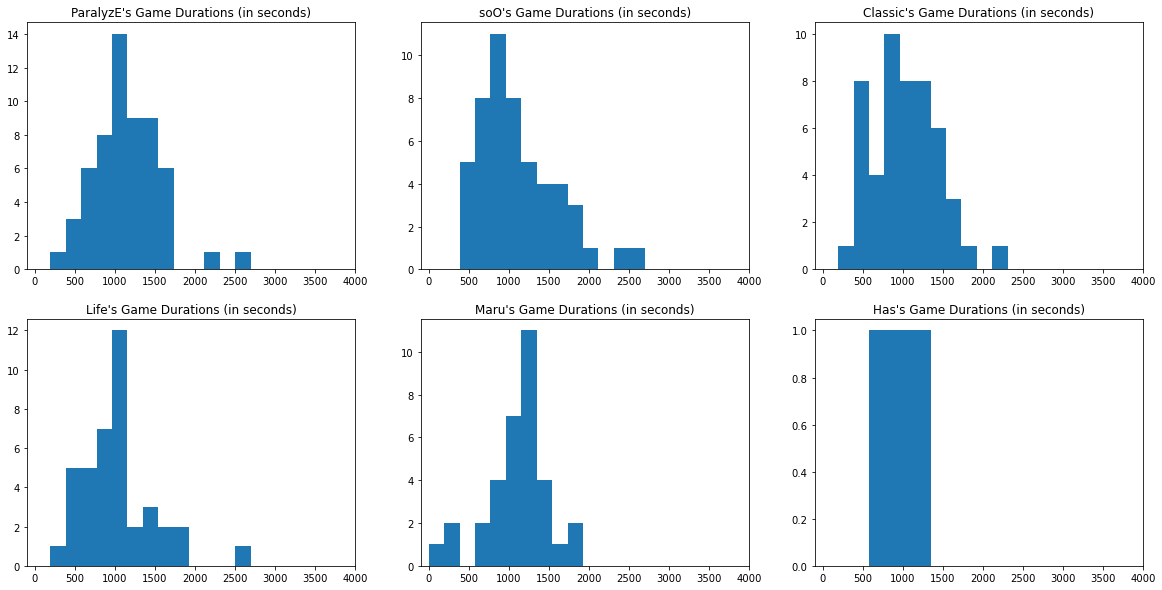

In [9]:
train_lengths = calculate_game_lengths(parsed_long_train)
test_lengths = calculate_game_lengths(parsed_long_test)

x_lim = [-100, 4000]
y_lim = [0, 600]

train_in_secs = train_lengths.divide(16)
test_in_secs = test_lengths.divide(16)
len_w_bn_url = pd.concat([bn_urls, train_in_secs], axis=1)

len_paralyze = len_w_bn_url.loc[len_w_bn_url["bn_url"] == bn_url_paralyze]["game_length"]
len_soo = len_w_bn_url.loc[len_w_bn_url["bn_url"] == bn_url_soo]["game_length"]
len_classic = len_w_bn_url.loc[len_w_bn_url["bn_url"] == bn_url_classic]["game_length"]
len_life = len_w_bn_url.loc[len_w_bn_url["bn_url"] == bn_url_life]["game_length"]
len_maru = len_w_bn_url.loc[len_w_bn_url["bn_url"] == bn_url_maru]["game_length"]
len_has = len_w_bn_url.loc[len_w_bn_url["bn_url"] == bn_url_has]["game_length"]

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Game Durations (in seconds)")
ax.set_xlim(x_lim)
_, bins, _ = ax.hist(train_in_secs, bins=30, label='train')
_, bins, _ = ax.hist(test_in_secs, bins=bins, label='test')
ax.legend()

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax0, ax1, ax2, ax3, ax4, ax5 = ax.flatten()

ax0.set_xlim(x_lim)
ax0.set_title("ParalyzE's Game Durations (in seconds)")
_, bins, _ = ax0.hist(len_paralyze, bins=bins)

ax1.set_xlim(x_lim)
ax1.set_title("soO's Game Durations (in seconds)")
_, bins, _ = ax1.hist(len_soo, bins=bins)

ax2.set_xlim(x_lim)
ax2.set_title("Classic's Game Durations (in seconds)")
_, bins, _ = ax2.hist(len_classic, bins=bins)

ax3.set_xlim(x_lim)
ax3.set_title("Life's Game Durations (in seconds)")
_, bins, _ = ax3.hist(len_life, bins=bins)

ax4.set_xlim(x_lim)
ax4.set_title("Maru's Game Durations (in seconds)")
_, bins, _ = ax4.hist(len_maru, bins=bins)

ax5.set_xlim(x_lim)
ax5.set_title("Has's Game Durations (in seconds)")
_, bins, _ = ax5.hist(len_has, bins=bins)

#### Game Results
In professional StarCraft II tournament games, most games end with one of the players conceding. Players do this by typing "gg" on the chat as a sign of surrendering. We can use this to determine whether the round has been won or lost by the player, 1 being a game won and 0 the contrary. What we can do, is to look at the last 10 actions for a ChatEvent and see if it contains the case-insensitive substring "gg" to obtain this information.

In [10]:
def get_game_results(games):
    game_results = []
    for index, game in games.iterrows():
        game_won = 1
        last_actions = game["actions"][-1: -11: -1] # Last 10 actions of the game
        for action in last_actions:
            if action[1] == "ChatEvent" and re.search("gg", action[2], re.IGNORECASE):
                game_won = 0
                break
        game_results.append(game_won)
    return pd.Series(game_results, name="game_result")

Here, we shall try to take a look at one of the players who played the most games in the tournament (ParalyzE) and another who played slightly lesser games (Life).

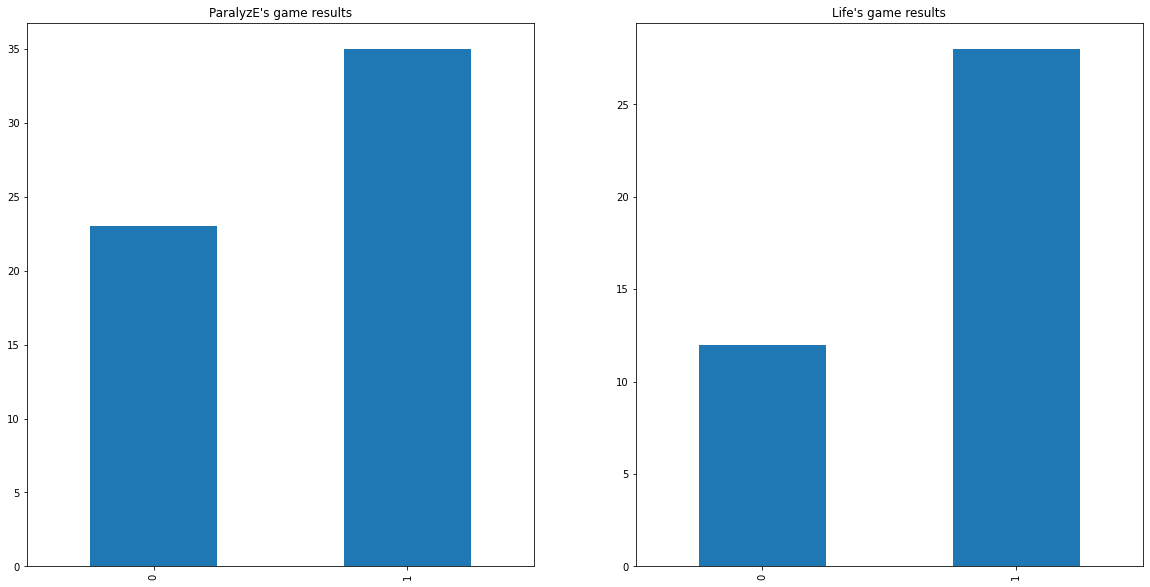

In [11]:
train_results = get_game_results(parsed_long_train)
test_results = get_game_results(parsed_long_test)

res_w_bn_url = pd.concat([bn_urls, train_results], axis=1)

res_paralyze = res_w_bn_url.loc[res_w_bn_url["bn_url"] == bn_url_paralyze]["game_result"]
res_life = res_w_bn_url.loc[res_w_bn_url["bn_url"] == bn_url_life]["game_result"]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax0, ax1 = ax.flatten()

ax0.set_title("ParalyzE's game results")
res_paralyze.value_counts().sort_index().plot.bar(ax=ax0)

ax1.set_title("Life's game results")
res_life.value_counts().sort_index().plot.bar(ax=ax1)

Here, we can see that Life has a larger difference between the number of wins and losses he had. This indicates that he most likely dominates his Bo3 or Bo5 games.

### Early Game Analysis
From this section onwards, all the analysis made on the players actions will only be made on the first 2 minutes (first 1920 frames). As mentioned before, this will increase the predictibility of the player due to unknown moves made by the opponent. The players actions are hence not affected by knowledge of the opponent's moves. During this time, players are concentrated on executing a few actions, namely :
* Collecting minerals
* Training workers
* Scouting (using workers or units such as the Overlord)
* Increasing supply
* Preparing for early aggression

#### Action frequencies
The first and most intuitive approach would be to calculate the frequency of each action event triggered till the 2-minute mark. This allows to naively evaluate a player's interaction in the game with minimal external influence, as this stage is prior scouting. We will try to distinguish events in the same event type to add a bit of resolution, whilst keeping it general enough by grouping similar actions.

For this, we start by defining several bins to help regroup and generalize events. We shall start by looking at the possible values of corresponding events.

In [12]:
possible_train

{'objects': {'',
  'Archon',
  'Armory',
  'Assimilator',
  'AutoTurret',
  'Baneling',
  'BanelingBurrowed',
  'BanelingCocoon',
  'BanelingNest',
  'Banshee',
  'Barracks',
  'BarracksFlying',
  'BarracksReactor',
  'BarracksTechLab',
  'BattleHellion',
  'Battlecruiser',
  'BroodLord',
  'BroodLordCocoon',
  'Broodling',
  'Bunker',
  'Carrier',
  'Changeling',
  'ChangelingMarine',
  'ChangelingMarineShield',
  'ChangelingZealot',
  'ChangelingZergling',
  'ChangelingZerglingWings',
  'CollapsibleRockTowerDebris',
  'CollapsibleRockTowerDebrisRampRight',
  'CollapsibleRockTowerDiagonal',
  'CollapsibleRockTowerRampRight',
  'Colossus',
  'CommandCenter',
  'CommandCenterFlying',
  'Corruptor',
  'CreepTumor',
  'CreepTumorBurrowed',
  'CreepTumorQueen',
  'CyberneticsCore',
  'DarkShrine',
  'DarkTemplar',
  'DestructibleDebris6x6',
  'DestructibleDebrisRampDiagonalHugeULBR',
  'DestructibleIce6x6',
  'DestructibleRampDiagonalHugeBLUR',
  'DestructibleRock6x6',
  'DestructibleRockE

With this, we define several groups to generalize the actions made by the user.

In [13]:
workers = {"Drone", "MULE", "SCV", "Probe"}

bases = {
    "CommandCenter", "CommandCenterFlying", "PlanetaryFortress", "OrbitalCommand", "OrbitalCommandFlying"
    "Hatchery", "Hive", "Lair",
    "Nexus"
}

With this, we shall calculate the frequency of each event with their respective distinctions up to a 2-minute mark. This analysis is made in bins of STEP seconds.

In [108]:
# Hyper-parameters in frames
LIMIT = 120 * 16 # Specifies the considered length of game to profile the player
STEP = 20 * 16 # Specifies an interval to partition the game

def get_freq(games, limit=LIMIT, step=STEP):
    result = []
    for index, game in games.iterrows():
        move_count = {}
        actions = []
        
        curr_step = 1
        curr_frame = 0
        for move in game["actions"]:
            curr_frame = int(move[0])
            event_type = move[1]
            data = move[2]
            
            # Distinguish events of the same category
            
            # Selections are distinguished to worker, base and mineral selections.
            # Other selections are grouped into a general bin
            if event_type == "SelectionEvent":
                if not set(data).isdisjoint(workers):
                    event = "SelectWorkers"
                elif not set(data).isdisjoint(bases):
                    event = "SelectBases"
                elif "MineralField" in set(data):
                    event = "SelectMinerals"
                else:
                    event = "Select"

            # For control group events, it will be handled more in detail in another section.
            # For now, we will just naively distinguish the different hotkeys and update types
            elif event_type == "ControlGroupEvent":
                hotkey, update_type = data
                event = f"hotkey_{hotkey}{update_type}"
            
            # No specific analysis is done for the camera event
            elif event_type == "CameraEvent":
                event = "Camera"
            
            # No specific analysis is done for the camera event
            elif event_type == "ChatEvent":
                event = "Chat"
            
            # For command events, we shall distinguish only commands to train workers
            # Due to difference in mechanics for the Zerg, commands to train overlords are seen as supply
            elif event_type == "BasicCommandEvent":
                if data == "MorphOverlord":
                    event = "Supply"
                elif data in {"MorphDrone", "TrainProbe", "TrainSCV"}:
                    event = "TrainWorker"
                else:
                    event = "BasicCommand"

            # For target point command events, we have principally building construction and unit movement
            elif event_type == "TargetPointCommandEvent":
                ability = data[-1]
                if ability in {"BuildPylon", "BuildSupplyDepot"}:
                    event = "Supply"
                elif "Build" in ability:
                    event = "ConstructBuilding"
                elif ability == "Move":
                    event = "MoveUnits"
                else:
                    event = "TargetPointCommand"

            # The last case would be the target unit command event
            else:
                event = "TargetUnitCommand"
            
            # Add event into count bucket
            if event in move_count:
                move_count[event] += 1
            else:
                move_count[event] = 1
            
            # Check if time limit exceeded
            if curr_frame >= limit: 
                break
            # Empty bucket corresponding to current step
            elif curr_frame >= curr_step * step: 
                period = curr_frame - (curr_step - 1) * step
                actions.append(pd.Series(move_count).add_prefix(f"s{curr_step}_").divide(period))
                move_count = {}
                curr_step += 1
        
        # Handle remaining actions
        if move_count: 
            period = curr_frame - (curr_step - 1) * step if curr_frame else step
            actions.append(pd.Series(move_count).add_prefix(f"s{curr_step}_").divide(period))
        
        result.append(pd.concat(actions))
    return pd.concat(result, axis=1).T
        
train_freq = get_freq(parsed_long_train)
test_freq = get_freq(parsed_long_test)

#### Hotkey Usage
Hotkey usage is primordial in the game of StarCraft, which is a RTS game. Hotkeys are what allows players to maximize the production and effectively control different groups of units. Hotkey preferences is a characterising factor. Players have preference for hotkeys that they use the most, prioritising some hotkeys more than others. This preference is evaluated on the scale of 1 to 10, where 10 is the hotkey used first, while 1 is the last hotkey to be used.

In [15]:
N_HOTKEYS = 10

def get_hk_pref(games, n_hk=N_HOTKEYS):
    prefs = []
    for index, game in games.iterrows():
        pref = {}
        
        hotkeys = set()
        for move in game["actions"]:
            frame, event, data = move
            if len(hotkeys) == n_hk:
                break
            elif event == "ControlGroupEvent":
                hotkey, update_type = data
                if len(hotkeys) < n_hk and hotkey not in hotkeys:
                    pref[f"hk_pref_{hotkey}"] = n_hk - len(hotkeys)
                    hotkeys.add(hotkey)
        prefs.append(pd.Series(pref, dtype="float32"))
    return pd.concat(prefs, axis=1).fillna(0).T

We shall visualize the preference for hotkeys of 2 different players throughout their games.

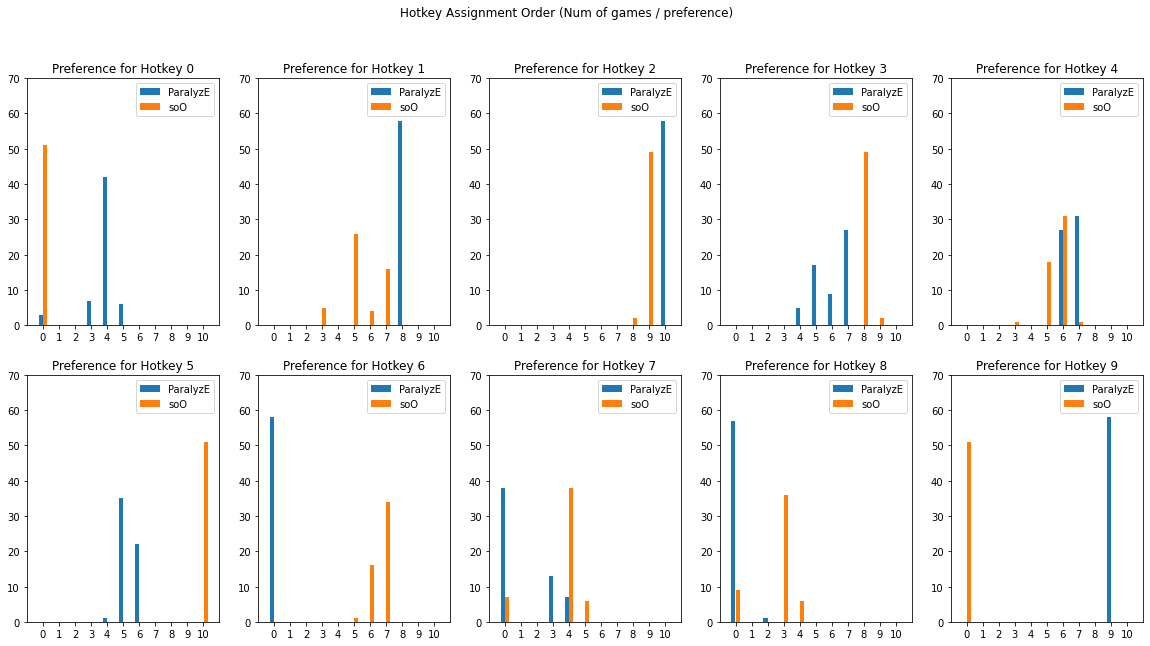

In [16]:
train_hk_pref = get_hk_pref(parsed_long_train)
test_hk_pref = get_hk_pref(parsed_long_test)

pref_w_bn_url = pd.concat([bn_urls, train_hk_pref], axis=1)
pref_paralyze = pref_w_bn_url.loc[pref_w_bn_url["bn_url"] == bn_url_paralyze]
pref_soo = pref_w_bn_url.loc[pref_w_bn_url["bn_url"] == bn_url_soo]

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle("Hotkey Assignment Order (Num of games / preference)")

xlim = [-1, 11]
ylim = [0, 70]

for i, axe in enumerate(ax.flatten()):
    hk_paralyze = pref_paralyze[f"hk_pref_{i}"].value_counts().reindex(range(11)).sort_index()
    hk_soo = pref_soo[f"hk_pref_{i}"].value_counts().reindex(range(11)).sort_index()
    axe.set_title(f"Preference for Hotkey {i}")
    
    axe.set_xticks(range(11))
    axe.set_xlim(xlim)
    axe.set_ylim(ylim)
    
    axe.bar([x-0.14 for x in range(11)], hk_paralyze, width=0.25, label="ParalyzE")
    axe.bar([x+0.14 for x in range(11)], hk_soo, width=0.25, label="soO")
    axe.legend(loc="upper right")

We can see here that ParalyzE systematically throughout his games assign the hotkey 2 first, the hotkey 9 second, and the hotkey 1 third. He also has a tendance of nearly not using at all the hotkeys 6 and 8. On the other side, we can see here a very different hotkey usage where soO systematically assigns the hotkey 5 first, then hotkey 2 and then hotkey 3. He also never uses hotkey 9 and 0, which are at the end of the keyboard.

#### Fidgeting / Warming up
An interesting phenomenon can also be observed where during the first few seconds of the game, where nothing much is happening and the player is waiting for either the training of workers to be done or to collect enough minerals, players tend to "fidget" and do "empty moves" to warm up. This phenomena concerns principally unit selections and hotkey usage. For this, we shall look at the amount of presses of hotkeys within the first 30 seconds, which will tell us which hotkey the player usually uses to fidget.

In [37]:
FIDGET_LIMIT = 30 * 16
FIDGET_STEP = 5 * 16

def get_hk_fidget(games, limit=FIDGET_LIMIT, step=FIDGET_STEP):
    fidgets = []
    for index, game in games.iterrows():
        fg_bins = []
        fidget = {}
        step_count = 1
        
        for move in game["actions"]:
            frame, event, data = move
            if event == "ControlGroupEvent":
                hotkey, update_type = data
                press = f"hk_fidget_{hotkey}{update_type}"
                if press in fidget:
                    fidget[press] += 1
                else:
                    fidget[press] = 1
                        
            if int(frame) > limit:
                break
            elif int(frame) > step_count * step:
                fg_bins.append(pd.Series(fidget, dtype="float32").divide(int(frame) / 16).add_prefix(f"t{step_count}_"))
                fidget = {}
                step_count += 1
        
        if fidget:
            fg_bins.append(pd.Series(fidget, dtype="float32").divide(int(frame) / 16).add_prefix(f"t{step_count}_"))
        else:
            fg_bins.append(pd.Series(dtype="object"))     
            
        fidgets.append(pd.concat(fg_bins))
    return pd.concat(fidgets, axis=1).fillna(0).T

We'll try to visualize the feature for 2 distinct players, to eventually identify the differences and validate the pertinence of this feature.

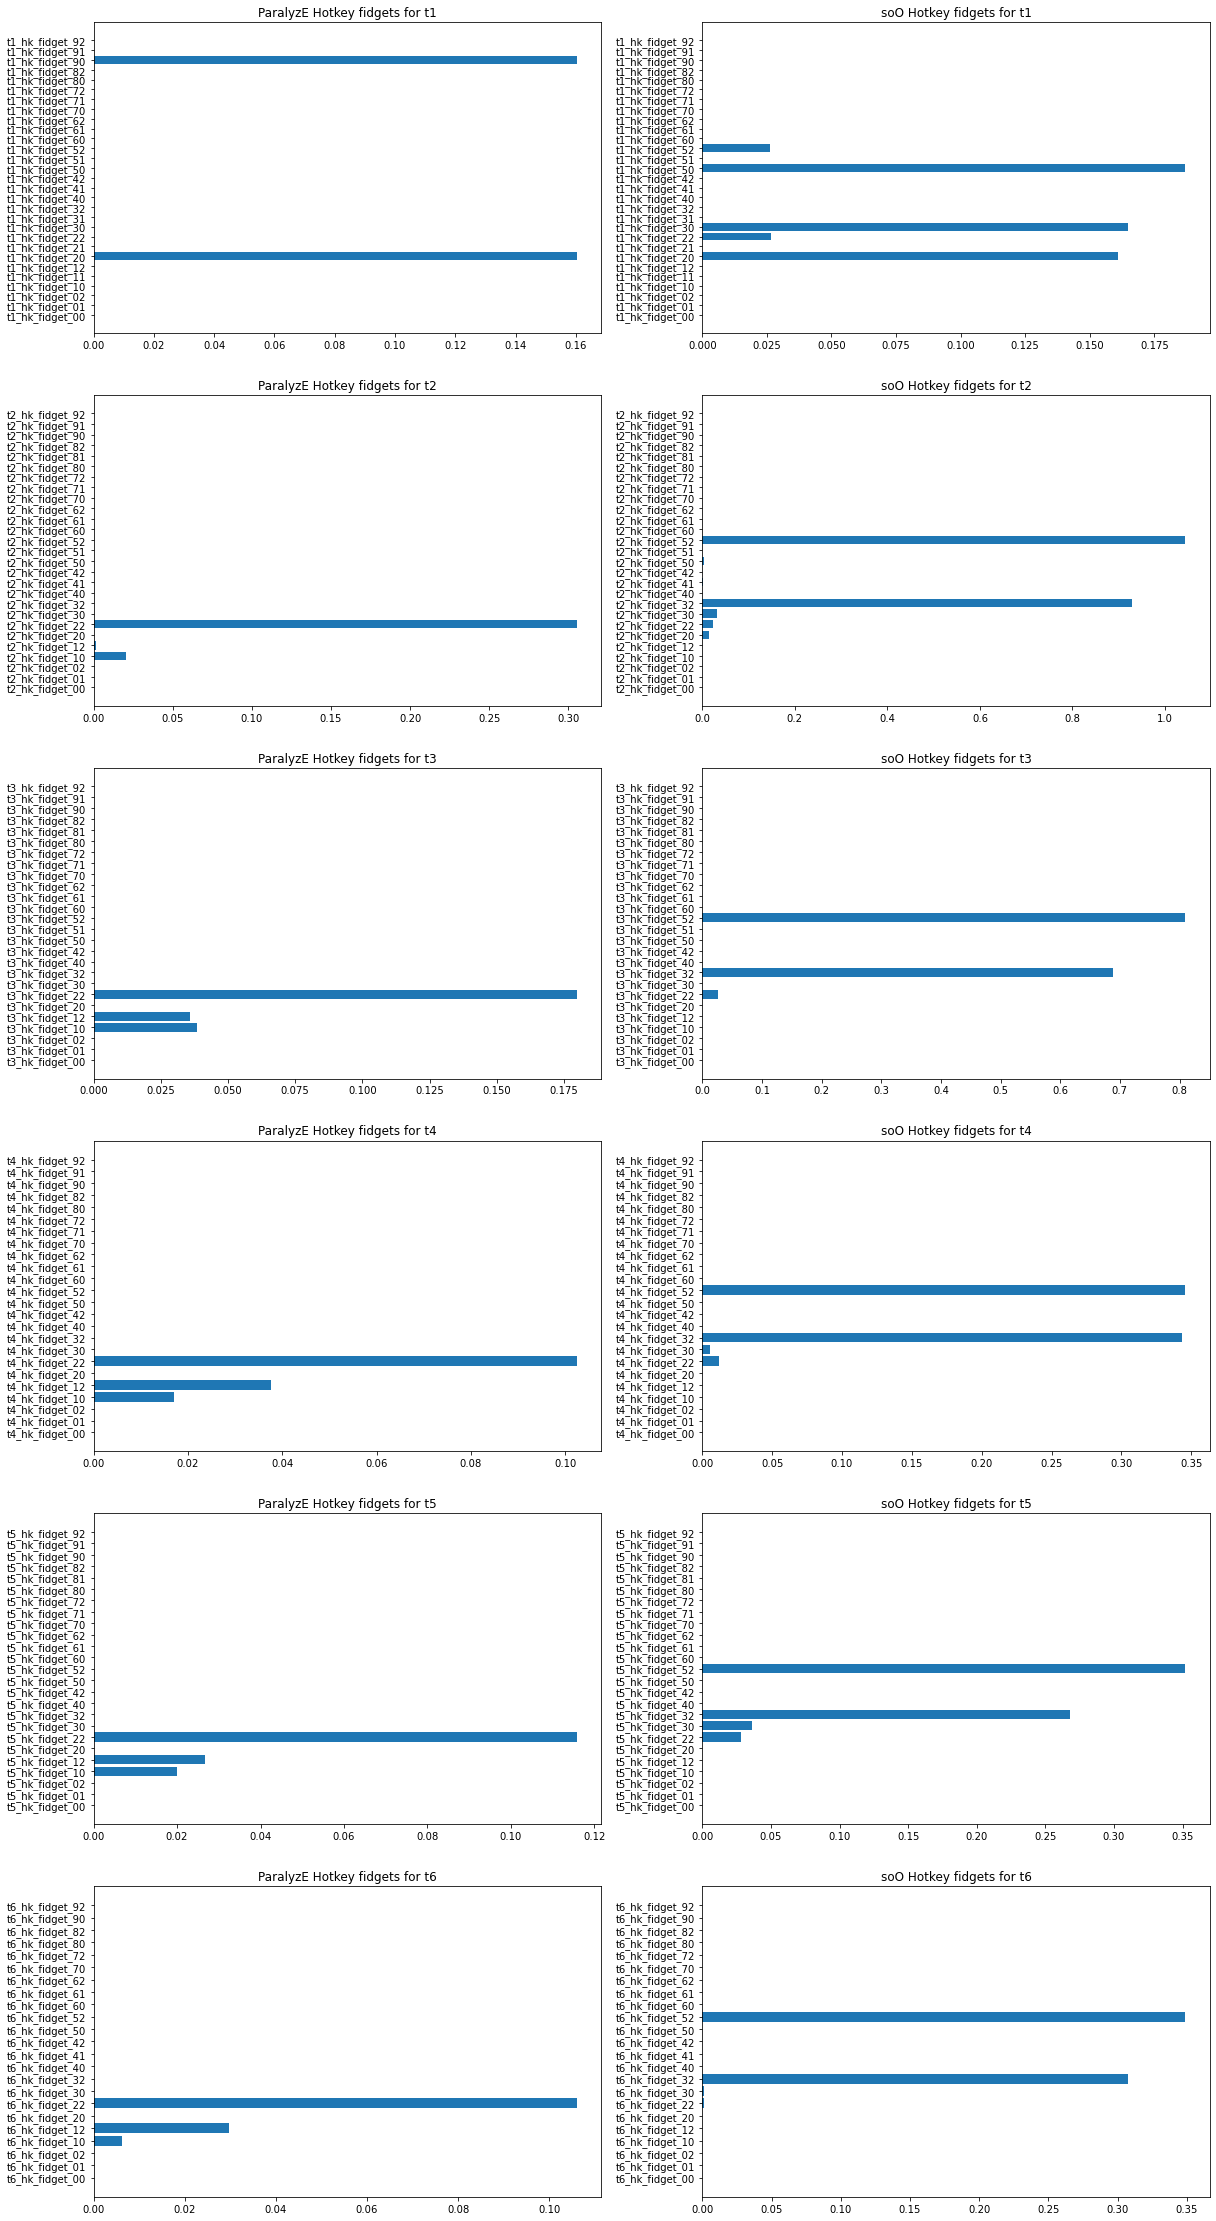

In [109]:
train_hk_fidget = get_hk_fidget(parsed_long_train)
test_hk_fidget = get_hk_fidget(parsed_long_test)

fidget_w_bn_url = pd.concat([bn_urls, train_hk_fidget], axis=1)
fidget_paralyze = fidget_w_bn_url.loc[fidget_w_bn_url["bn_url"] == bn_url_paralyze]
fidget_soo = fidget_w_bn_url.loc[fidget_w_bn_url["bn_url"] == bn_url_soo]

fig, ax = plt.subplots(6, 2, figsize=(20, 40))
ax = ax.flatten()

for i in range(1, 7):
    step_fidget_paralyze = fidget_paralyze.loc[:, fidget_paralyze.columns.str.contains(f"t{i}")].mean().sort_index()
    step_fidget_soo = fidget_soo.loc[:, fidget_soo.columns.str.contains(f"t{i}")].mean().sort_index()
    
    left_index = (i - 1) * 2
    right_index = i * 2 - 1
    
    ax[left_index].barh(step_fidget_paralyze.index, step_fidget_paralyze)
    ax[left_index].set_title(f"ParalyzE Hotkey fidgets for t{i}")
    
    ax[right_index].barh(step_fidget_soo.index, step_fidget_soo)
    ax[right_index].set_title(f"soO Hotkey fidgets for t{i}")

#### Build and Skill Timing
This section will try to study more on the strategies most comfortably used by the player. We will try to construct this feature by recording the first frames of each executed action or built buildings.

In [79]:
TIME_LIMIT = 10 * 60 * 16

def get_timing(games, limit=TIME_LIMIT):
    timing = []
    for index, game in games.iterrows():
        moves = {}
        for move in game["actions"]:
            frame, event, data = move
            if int(frame) > limit:
                break
            elif event == "TargetPointCommandEvent" and data[-1] not in moves:
                moves[data[-1]] = int(frame)
            elif event == "TargetUnitCommandEvent" and data[-2] not in moves:
                moves[data[-2]] = int(frame)
            elif event == "BasicCommandEvent" and data not in moves:
                moves[data] = int(frame)
        timing.append(pd.Series(moves, dtype="float32"))
    return pd.concat(timing, axis=1).T.fillna(0)

train_timing = get_timing(parsed_long_train)
test_timing = get_timing(parsed_long_test)

### Mid to End Game Analysis
In this section, we will be looking at the actions which are beyond the early game (in this case we consider the 5-minute mark as the line splitting the two). Analysis done in this section will mostly be independent of the strategic choices made by the player.

#### Average APM
The average APM determines how fast and accurate a player is, and if he is still able to be efficient in spite of stressful moments. This analysis is done in this part because during the early game, empty moves can be made and introduce noise to this analysis. This part of the game is where the map is starting to be populated and each action needs to be "meaningful" to maximize the players chances of beating the other. A player with a higher average "effective" APM is generally a higher-leveled player.

In [23]:
TIME_LIMIT = 5 * 60 * 16

def get_apm(games, limit=TIME_LIMIT):
    apms = []
    for index, game in games.iterrows():
        counter, frame = 0, 0
        for move in game["actions"]:
            frame = int(move[0])
            counter += 1
            if frame >= limit:
                break
        duration = int(game["actions"][-1][0]) - frame # in frames
        actions = len(game["actions"][counter:])
        if duration:
            apms.append(actions / duration * 16 * 60)
        else:
            apms.append(None) 
    result = pd.Series(apms, name="apm")
    return result.fillna(result.mean())

train_apm = get_apm(parsed_long_train)
test_apm = get_apm(parsed_long_test)

#### Average Hotkey Usage
Control groups are a fundamental part of StarCraft, or any other real time strategy game, where the player needs to control multiple groups of units or buildings to maximize the efficiency of actions. Although during the start of the game, it is quite complicated to detect patterns on the hotkey usage as nothing much is happening in the game and the players may just be fidgeting the hotkeys. Towards the mid and late game, more patterns should be seen in the different types of hotkey operations as players train and lose units etc. We will try to create the feature here.

In [87]:
TIME_LIMIT = 5 * 60 * 16

def get_hpm(games, limit=TIME_LIMIT):
    hpms = []
    for index, game in games.iterrows():
        counter, frame = 0, 0
        for move in game["actions"]:
            frame = int(move[0])
            counter += 1
            if frame >= limit:
                break
        
        duration = int(game["actions"][-1][0]) - frame
        count = {
            "hpm_0": 0,
            "hpm_1": 0,
            "hpm_2": 0
        }
        
        for move in game["actions"][counter:]:
            frame, event, data = move
            if event == "ControlGroupEvent":
                hotkey, update_type = data
                count[f"hpm_{update_type}"] += 1
        hpms.append(pd.Series(count).divide(duration / 16 / 60))
    result = pd.concat(hpms, axis=1).T
    return result.fillna(result.mean())

train_hpm = get_hpm(parsed_long_train)
test_hpm = get_hpm(parsed_long_test)

### Data Formatting
With all the features generated above, we shall concatenate all the features and associate it to the corresponding BattleNet URL to be feeded to the classifier.

In [138]:
pp_long_train = pd.concat([
    bn_urls,
    train_races,
    train_lengths,
    train_results,
    train_freq,
    train_hk_pref,
    train_hk_fidget,
    #train_timing,
    train_apm,
    train_hpm
], axis=1).fillna(0)

pp_long_test = pd.concat([
    test_races,
    test_lengths,
    test_results,
    test_freq,
    test_hk_pref,
    test_hk_fidget,
    #test_timing,
    test_apm,
    test_hpm
], axis=1).fillna(0)

x = pp_long_train.loc[:, pp_long_train.columns != "bn_url"]
y = pp_long_train.loc[:, "bn_url"]

pp_long_train.head()

,bn_url,Protoss,Terran,Zerg,game_length,game_result,s1_Camera,s1_SelectBases,s1_TrainWorker,s1_SelectWorkers,...,t5_hk_fidget_61,t3_hk_fidget_51,t1_hk_fidget_82,t1_hk_fidget_72,t1_hk_fidget_91,t5_hk_fidget_71,apm,hpm_0,hpm_1,hpm_2
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,1,0,0,26476,0,0.104938,0.006173,0.006173,0.012346,...,0.0,0.0,0.0,0.0,0.0,0.0,246.599004,4.960325,0.000000,50.710463
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,1,0,0,26493,1,0.006231,0.009346,0.006231,0.049844,...,0.0,0.0,0.0,0.0,0.0,0.0,193.692762,3.545052,0.132939,47.459380
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,1,0,0,16135,1,0.096875,0.006250,0.006250,0.018750,...,0.0,0.0,0.0,0.0,0.0,0.0,238.157918,2.625496,0.000000,51.408910
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,1,0,0,16128,0,0.006231,0.009346,0.006231,0.028037,...,0.0,0.0,0.0,0.0,0.0,0.0,195.071593,3.987979,0.084851,51.419480
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,1,0,0,8631,0,0.099071,0.006192,0.009288,0.015480,...,0.0,0.0,0.0,0.0,0.0,0.0,212.859755,3.008618,0.000000,41.619222


#### Cross Validation and Feature Importances

In [101]:
scores = []

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3)
for train_index, test_index in sss.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = RandomForestClassifier(random_state=17, n_estimators=500, class_weight=class_weights)
    clf.fit(x_train, y_train)
    scores.append(f1_score(y_test, clf.predict(x_test), average='micro'))
    
pd.Series(scores).describe()

count    5.000000
mean     0.931366
std      0.003130
min      0.926776
25%      0.931148
50%      0.931148
75%      0.932240
max      0.935519
dtype: float64

Having such a large number of features, we shall look at the top 100 features to have a look at which features characterize a player the most.

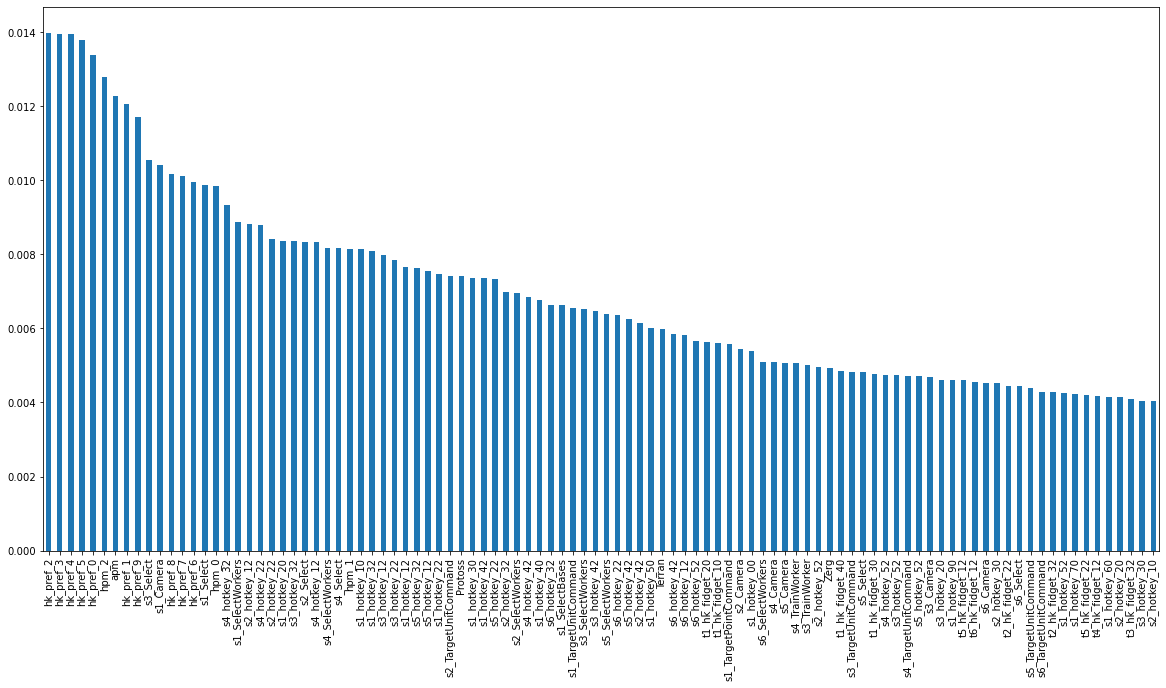

In [142]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)

for train_index, test_index in sss.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = RandomForestClassifier(random_state=17, n_estimators=500)
    clf.fit(x_train, y_train)

    feature_importance = pd.Series(clf.feature_importances_)
    feature_importance.index = x_train.columns
    feature_importance.sort_values(ascending=False)[:100].plot.bar(figsize=(20,10))

The importance measure generated above is an impurity-based feature importance. Using impurity based ranking for feature importance, there are a few points to note :
* Feature selection based on impurity reduction is biased towards preferring variables with more categories (high cardinality features)
* This measure is computed on statistics derived from the training dataset. This makes it unable to reflect the ability of the feature to be useful and generalized in the test dataset
* When there are two features that are correlated, any one can be used as the predictor, and the other feature will suffer a great reduction in importance because the impurity is already removed by the first

This is why we will use permutation importance to compute the feature importances, what this essentially does is permute the values and see how it affects the accuracy of the model.

In [140]:
result = permutation_importance(clf, x_test, y_test, n_repeats=5, random_state=17)

<BarContainer object of 100 artists>

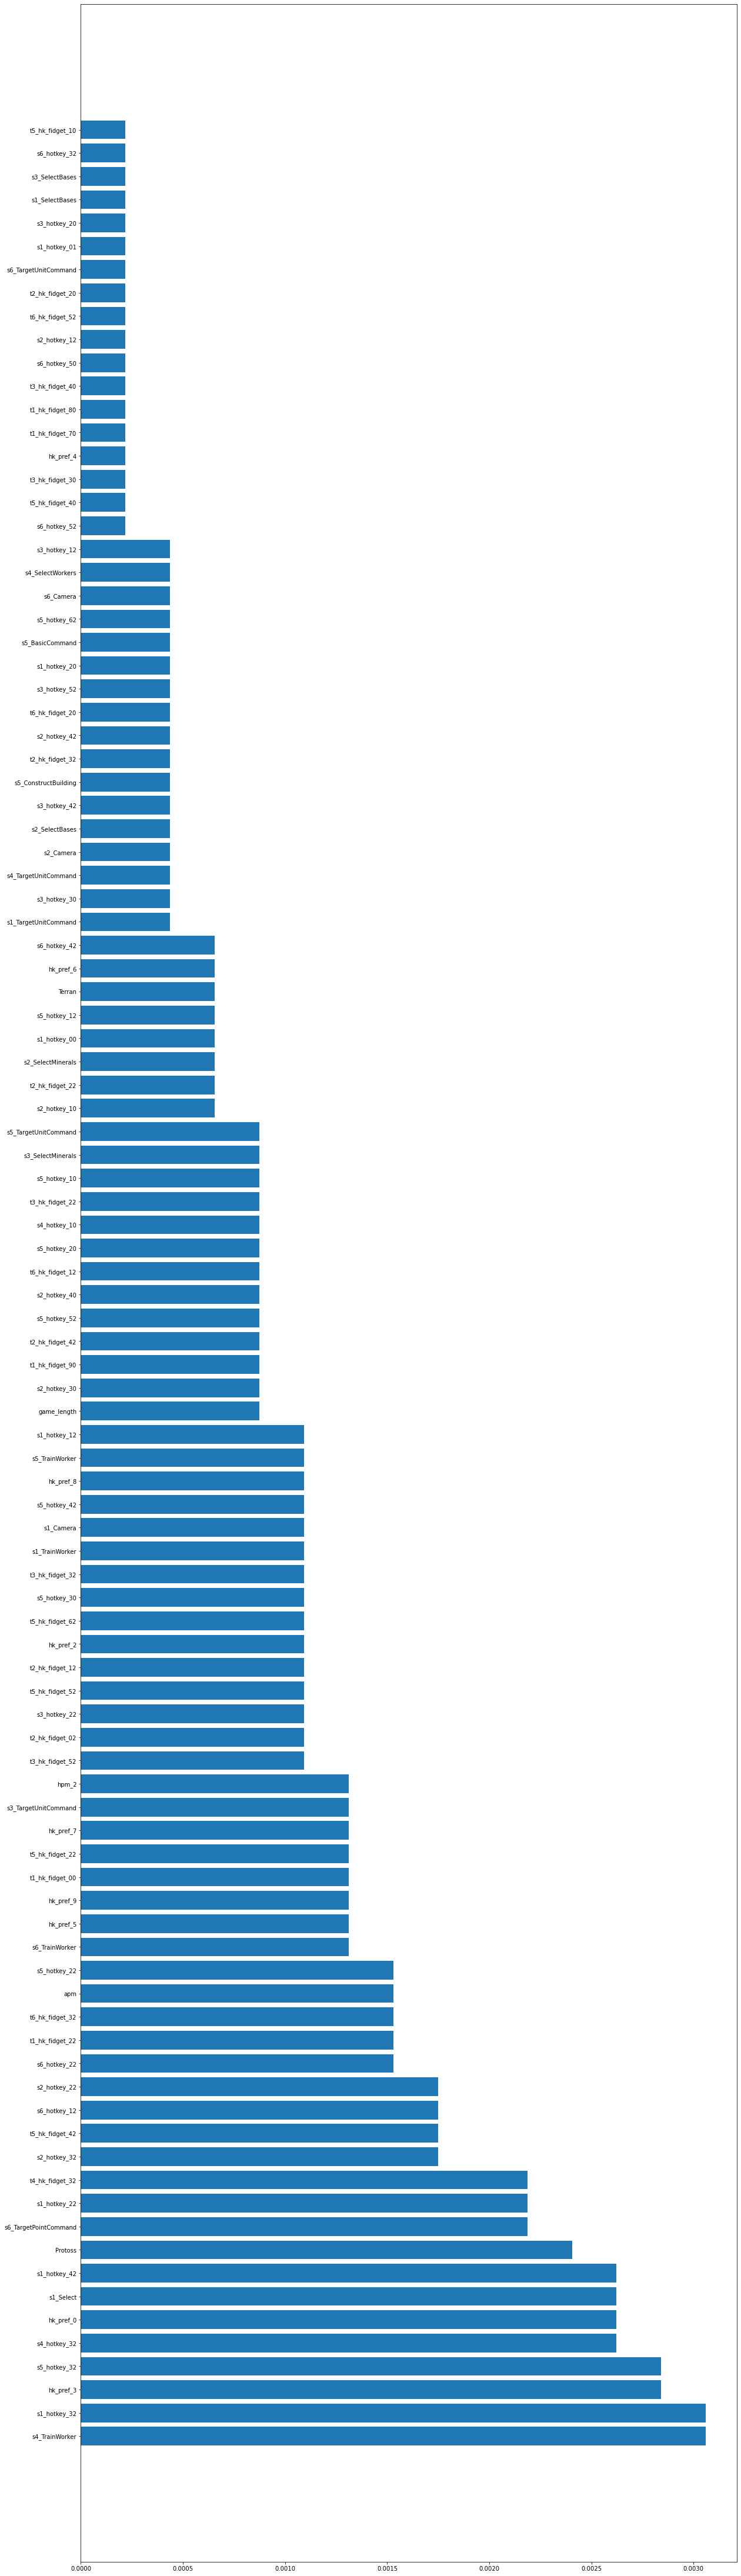

In [152]:
fig, ax = plt.subplots(figsize=(20, 80))
sorted_idx = result.importances_mean.argsort()[-1:-101:-1]
#whiskers = ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_test.columns[sorted_idx])
ax.barh(x_test.columns[sorted_idx], pd.Series(result.importances_mean[sorted_idx]))

#### Generate Submission

In [113]:
col_list = x.append([pp_long_test]).columns

x = pd.DataFrame(columns=col_list).append([x]).fillna(0)
use_test = pd.DataFrame(columns=col_list).append([pp_long_test]).fillna(0)

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(x, y)
prediction = clf.predict(use_test)
submission = pd.DataFrame({"RowId": range(1, 341), "prediction": prediction})
submission.to_csv("submission.csv", index=False)